N.B: To run this notebook, [McXtrace](https://www.mcxtrace.org/) needs to be installed. Some python libraries are also required such as [McStasScript](https://github.com/PaNOSC-ViNYL/McStasScript), [NumPy](https://numpy.org/), [SciPy](https://scipy.org/) and [matplotlib](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html).

# Summary

Scientists need to know where glitches occur to explain the sharp dips in intensity they observe in their results. In EXAFS measurements for example some glitches disappear due to ratio-ing out but not all do. By knowing where the glitches appear they can confirm that is, or is not, what they see in their results.  
Another possible use is to decide before the experiment is done the most suitable range of energy to use in order to avoid the maximum amount of glitches.  

In order to have this information one can refer to experimental data, such as the data found on ssrl glitch database, or to simulated data.

The work explained here concerns the latter, the Monte-Carlo x-ray simulation software McXtrace is used to find these glitches. The aim is to have a general purpose glitch "finder" or glitch "runner". 

To verify the validity of the simulation the results are compared with the experimental data of the ssrl glitch database.

Some python code that finds the positions of glitches is also used as a base of comparison. In the following text these glitches are called "theory glitches".  

To visualize and summarize the results an overlap of the ssrl glitch db data with the McXtrace data and the "theory glitches" data is plotted.  

When comparing McXtrace and the ssrl glitch database, glitches are found at the same positions for the same crystals and orientations. Work still needs to be done to get the same intensity deviation with McXtrace compared to the ssrl glitch database.  

# Table of contents <a name="toc"></a>
1. [Diffraction glitches](#diffraction_glitches)
1. [Simulations procedure](#simulations_procedure)
    1. [McXtrace simulation](#mcxtrace_simulation)
        1. [Beamline 11-2](#beamline_11_2) 
        1. [Orienting the (hkl) planes](#orienting_hkl_planes)
        1. [Two types of sources](#two_types_of_sources)
    1. [Run McXtrace simulations](#run_mcxtrace_simulations)
        1. [McStasScript](#mcstasscript)
    1. [Theory glitches simulation](#theory_glitches_simulation)
        
1. [Results](#results)
    1. [Theory glitches, ssrl-glitch and McXtrace data](#theory_ssrl_mcxtrace_data)
        1. [Plot notebook scan](#plot_notebook_scan)
        1. [Plots of entire range](#plot_entire_range)
1. [Interpretation](#interpretation)
    1. [Deviation intensity problem](#deviation_intensity_problem)
1. [Resources used](#resources_used) 

# Diffraction glitches <a name="diffraction_glitches"></a> 
[[back to toc]](#toc)

Glitches occur when, for a specific energy, the Bragg law is respected for multiple (hkl) planes at the same time (2 or more).  


d<sub>1</sub>\*sin(θ<sub>1</sub>) = d<sub>2</sub>\*sin(θ<sub>2</sub>) = ... = d<sub>n</sub>\*sin(θ<sub>n</sub>)

with d<sub>1</sub>, d<sub>2</sub>, ..., d<sub>n</sub> the interplanar spacings and θ<sub>1</sub>, θ<sub>2</sub>, ..., θ<sub>n</sub>  the Bragg angles in a glitch condition.

The primary plane of diffraction is the (hkl) plane that is oriented parallel to the crystal's surface. Due to one or more other planes partly diverting the rays, less rays are reflected off of the primary plane of diffraction.  
The beam signal lowers in intensity in a sharp manner.  

![glitches image](images/glitches_corrige_cropped.png)

# Simulations procedure  <a name="simulations_procedure"></a> 
[[back to toc]](#toc)

## McXtrace simulation <a name="mcxtrace_simulation"></a>
[[back to toc]](#toc)

### Beamline 11-2 <a name="beamline_11_2"></a>

The 11-2 beamline is described in detail [here](https://www-ssrl.slac.stanford.edu/mes/11-2/manual.php). 
Beamline 11-2's source is a 26 poles wiggler with a range of 4 to 40 keV, a 175mm period and a 2 Tesla magnet. It's horizontal and vertical divergence is respectively 1.5mrad and 0.15mrad.  
The ring current used is 0.1 A and the ring electron energy is 2.4 GeV.

The ssrl glitch data for the 11-2 beamline was made by using the beamline in the [unfocussed and uncollimated mode](https://www-ssrl.slac.stanford.edu/mes/Glitch_Curves/).
This means there is no focusing and collimating mirror. The ray hits the monochromator situated at 17.6m downstream from the source and is reflected towards the detector situated 27.5-29.5m downstream from the source.

### Orienting the (hkl) planes <a name="orienting_hkl_planes"></a>

#### ssrl's plots

Since the results will be compared with the ssrl glitch db data, the monochromators need to be oriented the same way ssrl has them oriented.
The aim is to reproduce the glitches found [here](https://www-ssrl.slac.stanford.edu/smbin/dataextractnew.pl) for the crystal Si 220 phi 90 (ssrl glitch db uses `phi 0` and `phi 90` notation that is explained [further below](#phi-0-and-phi-90)). 

In the picture below, the intensity deviation as a function of the energy is plotted for the crystal Si 220 with phi=90 for the beamline [BL 11-2](https://www-ssrl.slac.stanford.edu/content/beam-lines/bl11-2). Click [here](https://www-ssrl.slac.stanford.edu/smbin/dataextractnew.pl?trace1=si22090112&trace2=None&trace3=None&trace4=None&lowrange=4.5&highrange=27&graph=1&kvalyes=0) to access it directly on ssrl-glitch db.


![intensity deviation plot](images/ssrldb_si220_phi90_cropped.png)





#### Phi 0 and phi 90 notation
Phi 0 and phi 90 relate to how the crystal is positioned.  
For the beamline 11-2 case used in this notebook, only one position is used, PHI 90.  

The [220] hkl vector is normal to the crystal's surface. The two other vectors that make up the direct trihedron are along the [-11-2] and [-111] hkl vectors. The following picture illustrates this: 
![phi 0 and phi 90](images/phi_glitches.png)


Starting from the phi 0 position (left), the position ends up in the phi 90 position (right) after a -90 degrees rotation around the [220] hkl vector.  
ssrl uses a left handed coordinate system when it comes to the PHI 0 and PHI 90 notation. One can see that if the three vectors that made up the left handed coordinate system were the [220], [1-12] and [-111] hkl vectors then turning 90 degrees would be equivalent to the right handed coordinate system above.  

In the simulation of McXtrace the (hkl) planes need to be oriented properly.

#### Expressing the coordinates of the unit cell 

Any vector of the unit cell basis B can be expressed in the B<sub>hkl</sub> basis (the B<sub>hkl</sub> basis being the one represented in the above picture).
The [220] hkl vector is positioned along the normal to the plane, the [-11-2] hkl vector parallel to the long side of the crystal and the [-111] hkl vector parallel to the short side of the crystal. This configuration is represented on the right in the above picture. 

This is done in order to position ourselves on the B<sub>hkl</sub> basis, and express the unit cell basis B in it.
These coordinates are then written in the McXtrace .instr files in parameters called ax,ay,az, bx,by,bz and cx,cy,cz.

![basis explanation](images/basis_explanation_cropped.png)

The above is done in the following code. 

For this case, inputting the vector 100, 010 and 001 (the normalized vectors of the unit cell basis B) will give the ax,ay,az, bx,by,bz and cx,cy,cz written in the McXtrace simulation files.  

In [2]:
import math as m
import numpy as np

############## Returns vectors forming B and B_hkl
def vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3):
    ############## Express unit cell basis. The canonical basis B = {e1, e2, e3}.
    e1= np.array([[1,0,0]])
    e2= np.array([[0,1,0]])
    e3= np.array([[0,0,1]])

    ############## Express hkl1 hkl2 hkl3 in unit cell basis. The hkl basis, B_hkl = {hkl1, hkl2, hkl3}.
    hkl1 = np.array([xyz_hkl1])
    hkl1_norm = m.sqrt(np.dot(hkl1.reshape((1,3)),hkl1.reshape((3,1))))
    hkl1 = hkl1/hkl1_norm

    hkl2 = np.array([xyz_hkl2])
    hkl2_norm = m.sqrt(np.dot(hkl2.reshape((1,3)),hkl2.reshape((3,1))))
    hkl2 = hkl2/hkl2_norm

    hkl3 = np.array([xyz_hkl3])
    hkl3_norm = m.sqrt(np.dot(hkl3.reshape((1,3)),hkl3.reshape((3,1))))
    hkl3 = hkl3/hkl3_norm

    return e1,e2,e3,hkl1,hkl2,hkl3

#Input the three hkl vectors forming the B_hkl basis here.
xyz_hkl1 = [-1,1,-2]
xyz_hkl2 = [-1,1,1]
xyz_hkl3 = [2,2,0]

e1,e2,e3,hkl1,hkl2,hkl3 = vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3)

############## Change of basis matrix from basis B to B_hkl
def change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3):
    ############## change-of-basis matrix
    #https://www.youtube.com/watch?v=hVmcRYD1KFQ
    #https://www.youtube.com/watch?v=CNIN7UpyXvo
    mat2 = np.array([[np.dot(e1.reshape((1,3)),hkl1.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl1.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl1.reshape((3,1)))[0][0]],
                     [np.dot(e1.reshape((1,3)),hkl2.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl2.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl2.reshape((3,1)))[0][0]],
                     [np.dot(e1.reshape((1,3)),hkl3.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl3.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl3.reshape((3,1)))[0][0]]])
    return mat2
    
mat2 = change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3)

############## Express [xyz] vector in unit cell basis.
#[1,0,0] then [0,1,0] then [0,0,1] will be expressed.
def xyz_vector(x,y,z):
    xyz = np.array([[x,y,z]])
    #normalise it
    xyz_norm = m.sqrt(np.dot(xyz.reshape((1,3)),xyz.reshape((3,1))))
    xyz = xyz/xyz_norm
    return xyz

############## [1,0,0] is now expressed in the hkl basis B_hkl
xyz = xyz_vector(1,0,0)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[1,0,0] vector expressed in basis hkl: ", xyz_basis_hkl)

############## [0,1,0] is now expressed in the hkl basis B_hkl
xyz = xyz_vector(0,1,0)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[0,1,0] vector expressed in basis hkl: ", xyz_basis_hkl)

############## [0,0,1] is now expressed in the hkl basis B_hkl
xyz = xyz_vector(0,0,1)
xyz_basis_hkl = np.dot(mat2,xyz.reshape((3,1)))
print("[0,0,1] vector expressed in basis hkl: ", xyz_basis_hkl)

[1,0,0] vector expressed in basis hkl:  [[-0.40824829]
 [-0.57735027]
 [ 0.70710678]]
[0,1,0] vector expressed in basis hkl:  [[0.40824829]
 [0.57735027]
 [0.70710678]]
[0,0,1] vector expressed in basis hkl:  [[-0.81649658]
 [ 0.57735027]
 [ 0.        ]]


### Two types of sources  <a name="two_types_of_sources"></a>

The simulations are run for two types of sources: a white source and a nearly monochromatic source (dE). The nearly monochromatic source is used to get better statistics in the McXtrace simulations.  
It is meant by better statistics that there are more rays of the bragg energy hitting the crystals and being detected in the monitors. This is because the rays emitted by the source are contained in a narrower dE bandwith around the bragg energy. Whereas when the white source is used, the much larger dE bandwith will decrease the density of rays around the bragg energy.
Using the narrower dE source has also for effect to speed up the simulation runtime because it is possible to decrease the necessary number of rays thanks to the better statistics previously described.

#### White light, detuning for harmonic rejection

The white light source has a dE=18 keV and is centered on E=22 keV, the range is therefore from 4 to 40 keV. The higher harmonics are eliminated by detuning the second crystal.

##### Detuning

A rocking curve, calculated for a specific energy, was done in a simple manner by having the second crystal rotate and having a fixed slit and detector at the Bragg's angle of the selected energy.  

Detuning to remove the harmonics was done by rotating counter clock wise the second crystal by 50% of the rocking curve's full width half maximum.  

Best results are yielded with 50% of the rocking curve's fwhm for all points in the energy range being scanned.  

Below is a picture that explains the concept of detuning.

![detuning](images/detuning_explanation_done_cropped.png)  


#### Monochromatic light

The (nearly) monochromatic light source is centered on E has a dE of 100eV and scans an energy range 1eV at a time. The channel cut turns at the appropriate Bragg angle to select the energy of the source E.  
Detuning is not necessary for the monochromatic light because harmonics can't be present due to the source's small divergence.  
Chosing a source with a dE=1eV is also given as a possibility.  

## Run McXtrace simulations  <a name="run_mcxtrace_simulations"></a>
[[back to toc]](#toc)

### McStasScript  <a name="mcstasscript"></a>

[McStasScript](https://github.com/PaNOSC-ViNYL/McStasScript) is an API for creating and running McStas/McXtrace instruments from python scripting.  
It will be used in this notebook to create and run the McXtrace instruments.  
It is also possible to run these instruments independently from McStasScript.  
Two different instruments will be used, firstly a white source and then a (nearly) monochromatic light source, the latter used only for speeding up the simulation's runtime and better statistics.

#### White light 

##### Creation of the instrument 

In [1]:
import mcstasscript as ms

my_instrument = ms.McXtrace_instr("mcstasscript_bl_11_2_white_src",input_path="./running_mcxtrace/mcxtrace_bl_11_2_white_src")

############## Parameters of the instrument
dict_params = {}
dict_params["Etohit"] = "6900"
dict_params["h"] = "2"
dict_params["k"] = "2"
dict_params["l"] = "0"
dict_params["fwhm"] = 0.1
dict_params["detuning_percentage"] = 0 
dict_params["detuning_rockingcurve"] = 0

my_instrument.add_parameter("Etohit")
my_instrument.add_parameter("h")
my_instrument.add_parameter("k")
my_instrument.add_parameter("l")
my_instrument.add_parameter("fwhm")
my_instrument.add_parameter("detuning_percentage")
my_instrument.add_parameter("detuning_rockingcurve")

my_instrument.set_parameters(dict_params)

my_instrument.add_declare_var("double", "n")
my_instrument.add_declare_var("double", "calculated_angle")
my_instrument.add_declare_var("double", "theta_detuning")

my_instrument.append_initialize("n = h*h + k*k + l*l;")
my_instrument.append_initialize("fprintf(stdout,\"n %g \\n\", n);")
my_instrument.append_initialize("calculated_angle=RAD2DEG*asin(12398.4198*sqrt(n)/(2*5.43096*Etohit));")
my_instrument.append_initialize("fprintf(stdout,\"Energy eV %g / Angle deg %g \\n\", Etohit, calculated_angle);")
my_instrument.append_initialize("//the fwhm is 0.1 degrees by default, the value for the for 6900-7500 eV range. For other ranges find it by doing a scan with the detuning_rockingcurve parameter.")
my_instrument.append_initialize("theta_detuning=(detuning_percentage/100)*fwhm;")
my_instrument.append_initialize("fprintf(stdout,\"theta_detuning degrees %g \\n\", theta_detuning);")    

############## Add all the components
my_origin = my_instrument.add_component("Origin", "Progress_bar", AT=[0,0,0])

my_source = my_instrument.add_component("src", "Wiggler", AT=[0,0,0], RELATIVE="PREVIOUS")
my_source.E0 = 22
my_source.dE = 18
my_source.B = 2
my_source.Nper = 13
my_source.Ie = 0.1
my_source.length = 175e-3
my_source.Ee = 2.4
my_source.focus_xw = "2*tan(0.0015/2)"
my_source.focus_yh = "2*tan(0.00015/2)"

my_slit_mono = my_instrument.add_component("slit_mono", "Slit", AT=[0,0,17.6-0.08], RELATIVE="PREVIOUS")
my_slit_mono.xwidth = 0.005
my_slit_mono.yheight = 0.0003

my_mono_loc = my_instrument.add_component("mono_loc", "Arm", AT=[0,0,0.08], RELATIVE="PREVIOUS")

#ray's position, this is used to place monitors after the dcm
my_ray_position = my_instrument.add_component("ray_position", "Arm", AT=[0,0,0], RELATIVE="PREVIOUS")

# -------------------------------------------------------------------------- Double crystal monochromator 
my_mono_rotation = my_instrument.add_component("mono_rotation", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=[-90,0,0], ROTATED_RELATIVE="PREVIOUS")

my_mono_rotation_phi_90 = my_instrument.add_component("mono_rotation_phi_90", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=[0,0,-90], ROTATED_RELATIVE="PREVIOUS")

#0.006 works too though
my_center_of_rotation = my_instrument.add_component("center_of_rotation", "Arm", AT=[0,0,0.004], AT_RELATIVE="PREVIOUS", ROTATED=[0,"-calculated_angle",0], ROTATED_RELATIVE="PREVIOUS")

my_bragg_crystal_split = my_instrument.add_component("bragg_crystal_split", "Single_crystal", AT=[-0.0762/2, 0, -0.006/2-(0.001/2)], AT_RELATIVE="PREVIOUS",ROTATED=[0,0,0], ROTATED_RELATIVE="PREVIOUS")

my_bragg_crystal_split.reflections = "\"Si.lau\""
my_bragg_crystal_split.material = "\"Si.txt\""
my_bragg_crystal_split.xwidth = 76.2e-3
my_bragg_crystal_split.yheight =  41.275e-3
my_bragg_crystal_split.zdepth = 0.001
my_bragg_crystal_split.p_transmit = -1
my_bragg_crystal_split.order = 1
my_bragg_crystal_split.mosaic = 1
my_bragg_crystal_split.barns = 1
my_bragg_crystal_split.ax = -5.43096*0.40824829
my_bragg_crystal_split.ay = -5.43096*0.57735027
my_bragg_crystal_split.az = 5.43096*0.70710678
my_bragg_crystal_split.bx = 5.43096*0.40824829
my_bragg_crystal_split.by = 5.43096*0.57735027
my_bragg_crystal_split.bz = 5.43096*0.70710678
my_bragg_crystal_split.cx = -5.43096*0.81649658
my_bragg_crystal_split.cy = 5.43096*0.57735027
my_bragg_crystal_split.cz = 5.43096*0
my_bragg_crystal_split.append_EXTEND("if(!SCATTERED) ABSORB;")
my_bragg_crystal_split.set_SPLIT(10)

my_mono_loc_2 = my_instrument.add_component("mono_loc_2", "Arm", AT=[0.09525/2, 0, 0.006/2+(0.001/2)], RELATIVE="center_of_rotation")

#counter clock wise detuning
#use detuning_rockingcurve or theta_detuning, not both
my_detuning_rotation = my_instrument.add_component("detuning_rotation", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=[0,"-detuning_rockingcurve-theta_detuning",0], ROTATED_RELATIVE="PREVIOUS")

my_bragg_crystal_two_split = my_instrument.copy_component("bragg_crystal_two_split", "bragg_crystal_split", AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[0,0,0], ROTATED_RELATIVE="PREVIOUS")
my_bragg_crystal_two_split.xwidth = 95.25e-3
my_bragg_crystal_two_split.append_EXTEND("if(!SCATTERED) ABSORB;")
my_bragg_crystal_two_split.set_SPLIT(10)

# -------------------------------------------------------------------------- Energy monitors
my_EnergyMonitor_first = my_instrument.add_component("EnergyMonitor_first", "Monitor_nD", AT=[0, "0.006*sin(DEG2RAD*2*calculated_angle)/sin(DEG2RAD*calculated_angle)", 18.6-17.6], RELATIVE="ray_position")
my_EnergyMonitor_first.xwidth = 44e-4
my_EnergyMonitor_first.yheight = 44e-4
my_EnergyMonitor_first.min = 4
my_EnergyMonitor_first.max =  40
my_EnergyMonitor_first.bins = 500
my_EnergyMonitor_first.options = "\"energy\""
my_EnergyMonitor_first.filename = "\"EnergyMonitor_first\""
my_EnergyMonitor_first.restore_xray = 1

my_EnergyMonitor_second = my_instrument.copy_component("EnergyMonitor_second", "EnergyMonitor_first", AT=[0, 0, 0], RELATIVE="PREVIOUS")
my_EnergyMonitor_second.xwidth = 2.8e-3
my_EnergyMonitor_second.yheight = 2.8e-3
my_EnergyMonitor_second.filename = "\"EnergyMonitor_second\""

my_EnergyMonitor_third = my_instrument.copy_component("EnergyMonitor_third", "EnergyMonitor_first", AT=[0, 0, 10], RELATIVE="PREVIOUS")
my_EnergyMonitor_third.xwidth = 1e-2
my_EnergyMonitor_third.yheight = 1e-2
my_EnergyMonitor_third.filename = "\"EnergyMonitor_third\""

my_EnergyMonitor_fourth = my_instrument.copy_component("EnergyMonitor_fourth", "EnergyMonitor_first", AT=[0, 0, 0], RELATIVE="PREVIOUS")
my_EnergyMonitor_fourth.xwidth = 4.3e-3
my_EnergyMonitor_fourth.yheight = 4.3e-3
my_EnergyMonitor_fourth.filename = "\"EnergyMonitor_fourth\""

#this monitor takes into account the detuning that shifts the beam upwards by theta_detuning
my_EnergyMonitor_fifth = my_instrument.copy_component("EnergyMonitor_fifth", "EnergyMonitor_first", AT=[0, "0.006*sin(DEG2RAD*2*calculated_angle)/sin(DEG2RAD*calculated_angle)+11*tan(DEG2RAD*theta_detuning)", 11], RELATIVE="ray_position")
my_EnergyMonitor_fifth.xwidth = 44e-3 #44e-3,
my_EnergyMonitor_fifth.yheight = 5.4e-3 #4.4e-3 but we add 1 mm because the 11metre distance is approximative, and 1metre more in distance for the monitor => vertical shift of approx 1mm
my_EnergyMonitor_fifth.filename = "\"EnergyMonitor_fifth\""

############## Ask number of cores to use for mpi, 60 by default
try:
    mpi_cores = int(input("Input number of cores to use with mpi (60 by default):"))
except ValueError:
    mpi_cores = 60

my_instrument.settings(output_path="./running_mcxtrace/mcxtrace_bl_11_2_white_src/rocking_curve/bl_11_2_white_src_res", mpi=mpi_cores, ncount=1E7)
print("Instrument BL 11-2 white source configured.")

Input number of cores to use with mpi (60 by default):
Instrument BL 11-2 white source configured.


##### Rocking curve, detuning

Do the rocking curve of a chosen energy. 

Input angle(>0 deg, typically 0.1 deg) the 2nd crystal rocks from [-angle/2,angle/2]:0.1
Input number of points in the scan, typically 20 points:25
Input the energy to select with the monochromator:13420
initial angle: -0.1
Energy to select with the monochromator is: 13420.0
Input the number of the monitor to plot( monitor 1 by default):


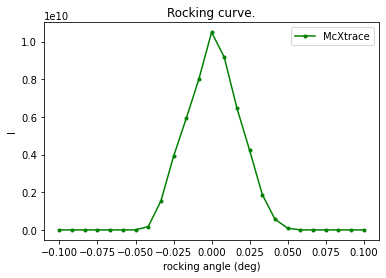

fwhm:  [0.04063158]


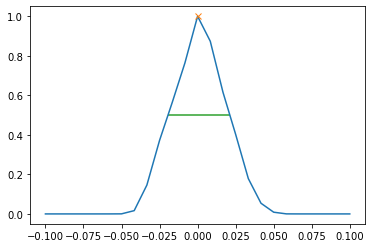

In [4]:
# ---------------------------------------------------- Input rocking angle in degrees (0.1 deg for ex)
# and the number of points in the scan (25 for ex)
rocking_angle = float(input("Input angle(>0 deg, typically 0.1 deg) the 2nd crystal rocks from [-angle/2,angle/2]:")) 
nb_pts_scan = int(input("Input number of points in the scan, typically 20 points:")) 
energy_choice = float(input("Input the energy to select with the monochromator:")) 

rocking_angle_scan_range = []
angle = -rocking_angle
print("initial angle:" ,angle)

angle_step = 2*rocking_angle /  (nb_pts_scan-1)
while angle<=rocking_angle:
    rocking_angle_scan_range.append(angle)    
    angle += angle_step

#print("list of angles: ",rocking_angle_scan_range)

data_list = []
dict_params["Etohit"] = str(energy_choice)
print("Energy to select with the monochromator is:",dict_params["Etohit"])

#hide McXtrace's output to not clutter the notebook
my_instrument.settings(suppress_output=True)

for angle in rocking_angle_scan_range:
    dict_params["detuning_rockingcurve"] = angle
    
    #print on the same line       
    try:
        print(len(text_to_print_angle)*' ',end='\r')
    except NameError:
        pass
    text_to_print_angle = "running simulation for angle: "+str(angle)
    print(text_to_print_angle,end='\r')
    
    my_instrument.set_parameters(dict_params)
    data = my_instrument.backengine()
    data_list.append(data)
    my_instrument.settings(force_compile=False)

my_instrument.settings(force_compile=True)

# ---------------------------------------------------- Writing to file
#writing the equivalent of mccode.dat, getting the total intensity of the 4 monitors
counter = 0

with open('./running_mcxtrace/mcxtrace_bl_11_2_white_src/rocking_curve/mccode_mcstasscript_rocking_angle.dat', 'w') as f:    
    for angle in rocking_angle_scan_range:
        f.write(str(angle))
        f.write(" "+data_list[counter][0].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][1].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][2].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][3].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][4].metadata.info['values'].split(" ")[0])                
        f.write("\n")    
        counter+=1

import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------- Plotting rocking angle
########### Get data from McXtrace's mccode_mcstasscript_rocking_angle.dat
try:
    monitor_number = int(input("Input the number of the monitor to plot( monitor 1 by default):")) 
except ValueError:
    monitor_number = 1

data_mcxtrace = np.loadtxt("./running_mcxtrace/mcxtrace_bl_11_2_white_src/rocking_curve/mccode_mcstasscript_rocking_angle.dat")
size_data_mcxtrace = len(data_mcxtrace)
X_rocking = np.zeros(size_data_mcxtrace)
Y_rocking = np.zeros(size_data_mcxtrace)

i=0
for elt in data_mcxtrace:    
    X_rocking[i]=elt[0]
    Y_rocking[i]=elt[monitor_number]
    i+=1

plt.title("Rocking curve.")
plt.xlabel("rocking angle (deg)")
plt.ylabel("I")
plt.plot(X_rocking, Y_rocking, marker='.', color="g", label='McXtrace')
plt.legend(fontsize=10)
plt.show()

import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
import fwhm_module

########### Plot and give the full width half maximum of the rocking curve
fwhm_module.fwhm_and_plot(data_mcxtrace,monitor_number)

##### Comparing with and without detuning

Compare the energy monitor with and without detuning.  

Input fwhm of the rocking curve found for that energy(deg):0.04063158
Input percentage of the fwhm to detune the second crystal by (40 or 50 for example) (%):110
Input the energy to select with the monochromator:13420
running simulation with the 2nd crystal detuned by  110.0 % of the fwhm =  0.04063158
running simulation with the 2nd crystal not detuned.
Input the number of the monitor to plot( monitor 1 by default):
With detuning, no or little harmonics.


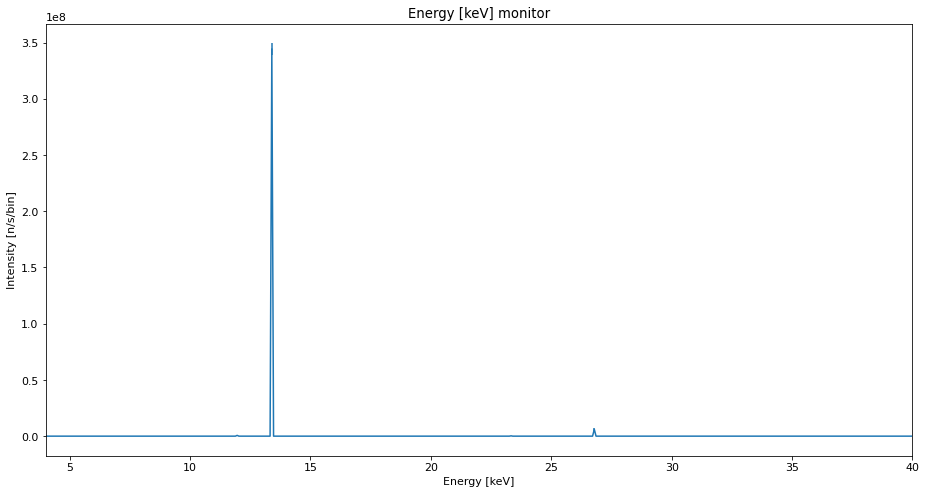

Without detuning, harmonics are present.


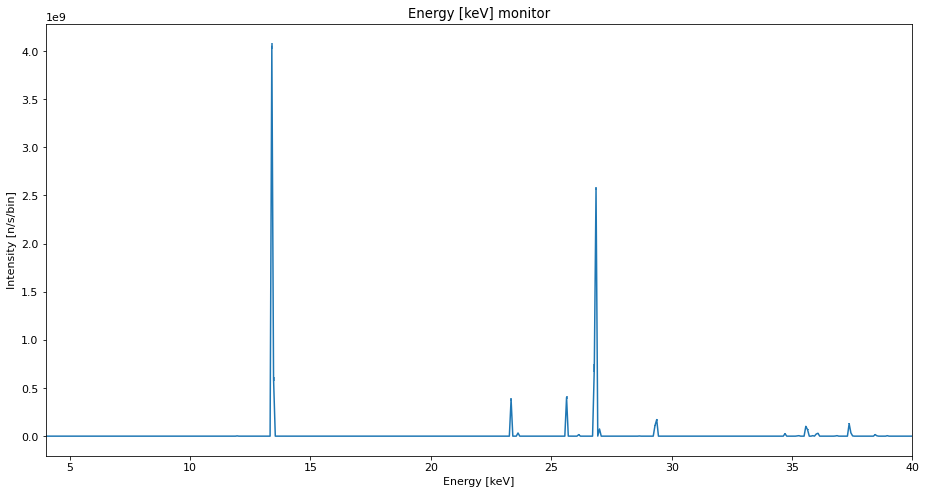

In [9]:
# ---------------------------------------------------- Input fwhm of the rocking curve above for that energy
fwhm_of_rocking_curve = float(input("Input fwhm of the rocking curve found for that energy(deg):")) 
det_percent_of_rocking_curve = float(input("Input percentage of the fwhm to detune the second crystal by (40 or 50 for example) (%):")) 
energy_choice = float(input("Input the energy to select with the monochromator:")) 

dict_params["Etohit"] = str(energy_choice)
dict_params["fwhm"] = fwhm_of_rocking_curve #0.1
dict_params["detuning_percentage"] = det_percent_of_rocking_curve
#put this back to 0
dict_params["detuning_rockingcurve"] = 0

print("running simulation with the 2nd crystal detuned by ",det_percent_of_rocking_curve, "% of the fwhm = ",
      fwhm_of_rocking_curve)

#hide McXtrace's output to not clutter the notebook
my_instrument.settings(suppress_output=True)

my_instrument.set_parameters(dict_params)
data = my_instrument.backengine()
data_list = []
data_list.append(data)

print("running simulation with the 2nd crystal not detuned.")
dict_params["detuning_percentage"] = 0

my_instrument.set_parameters(dict_params)
data = my_instrument.backengine()
data_list.append(data)

try:
    monitor_number = int(input("Input the number of the monitor to plot( monitor 1 by default):")) 
except ValueError:
    monitor_number = 1
    
print("With detuning, no or little harmonics.")
ms.make_sub_plot(data_list[0][monitor_number-1])

print("Without detuning, harmonics are present.")
ms.make_sub_plot(data_list[1][monitor_number-1])

#You can also look at the 5 monitors at the same time instead of the first only, uncomment below if you wish to do so
#print("All monitors")
#ms.make_sub_plot(data_list[0])
#ms.make_sub_plot(data_list[1])

##### Energy scan 

Chose the energy range to scan for with the channel cut. 

In [10]:
# ---------------------------------------------------- Input energy range to scan
energy_initial = int(input("Input initial energy(eV):"))
energy_final = int(input("Input final energy(eV):"))
energy_scan_range = []

egy = energy_initial
while egy<=energy_final:
    energy_scan_range.append(str(egy))
    egy+=1

data_list = []

#hide McXtrace's output to not clutter the notebook
my_instrument.settings(suppress_output=True)

for energy in energy_scan_range:
    dict_params["Etohit"] = energy
    
    #print on the same line       
    try:
        print(len(text_to_print_egy)*' ',end='\r')
    except NameError:
        pass
    text_to_print_egy = "running simulation for energy: "+energy
    print(text_to_print_egy,end='\r')
    
    my_instrument.set_parameters(dict_params)
    data = my_instrument.backengine()
    data_list.append(data)
    my_instrument.settings(force_compile=False)
    
my_instrument.settings(force_compile=True)

#writing the equivalent of mccode.dat, getting the total intensity of the 4 monitors
counter = 0
with open('./running_mcxtrace/mcxtrace_bl_11_2_white_src/energy_scan/mccode_mcstasscript_white_src.dat', 'w') as f:    
    for energy in energy_scan_range:
        f.write(energy)
        f.write(" "+data_list[counter][0].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][1].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][2].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][3].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][4].metadata.info['values'].split(" ")[0])
        f.write("\n")    
        counter+=1
        
print("Instrument BL 11-2 white source run.")

Input initial energy(eV):13420
Input final energy(eV):13422
Instrument BL 11-2 white source run.


#### Monochromatic light
##### Creation of the instrument and energy scan

In [12]:
import mcstasscript as ms

my_instrument = ms.McXtrace_instr("mcstasscript_bl_11_2_not_white_src",input_path="./running_mcxtrace/mcxtrace_bl_11_2_not_white_src")

############## Parameters of the instrument
dict_params = {}
dict_params["Etohit"] = "6900"
dict_params["h"] = "2"
dict_params["k"] = "2"
dict_params["l"] = "0"

my_instrument.add_parameter("Etohit")
my_instrument.add_parameter("h")
my_instrument.add_parameter("k")
my_instrument.add_parameter("l")

my_instrument.set_parameters(dict_params)

my_instrument.add_declare_var("double", "n")
my_instrument.add_declare_var("double", "calculated_angle")

my_instrument.append_initialize("n = h*h + k*k + l*l;")
my_instrument.append_initialize("fprintf(stdout,\"n %g \\n\", n);")
my_instrument.append_initialize("calculated_angle=RAD2DEG*asin(12398.4198*sqrt(n)/(2*5.43096*Etohit));")
my_instrument.append_initialize("fprintf(stdout,\"Energy eV %g / Angle deg %g \\n\", Etohit, calculated_angle);")
    
############## Add all the components    
my_origin = my_instrument.add_component("Origin", "Progress_bar", AT=[0,0,0])

#Ask if the source(narrow bandwith of dE=100eV) or monochromatic source(dE=1eV) is to be used
source_choice = int(input("(choice:0) source(narrow bandwith of dE=100eV) or (choice:1) source(narrow bandwith of dE=1eV):"))

# -------------------------------------------------- Source 
my_source = my_instrument.add_component("src", "Wiggler", AT=[0,0,0], RELATIVE="PREVIOUS")
if(source_choice==0):
    my_source.E0 = "Etohit/1000"
    my_source.dE = 100/1000
else:
    my_source.E0 = "Etohit/1000"
    my_source.dE = 1/1000
my_source.B = 2
my_source.Nper = 13
my_source.Ie = 0.1
my_source.length = 175e-3
my_source.Ee = 2.4
my_source.focus_xw = "2*tan(0.0015/2)"
my_source.focus_yh = "2*tan(0.00015/2)"

my_slit_mono = my_instrument.add_component("slit_mono", "Slit", AT=[0,0,17.6-0.08], RELATIVE="PREVIOUS")
my_slit_mono.xwidth = 0.005
my_slit_mono.yheight = 0.0003

my_mono_loc = my_instrument.add_component("mono_loc", "Arm", AT=[0,0,0.08], RELATIVE="PREVIOUS")

#ray's position, this is used to place monitors after the dcm
my_ray_position = my_instrument.add_component("ray_position", "Arm", AT=[0,0,0], RELATIVE="PREVIOUS")

# -------------------------------------------------------------------------- Double crystal monochromator 
my_mono_rotation = my_instrument.add_component("mono_rotation", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=[-90,0,0], ROTATED_RELATIVE="PREVIOUS")

my_mono_rotation_phi_90 = my_instrument.add_component("mono_rotation_phi_90", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=[0,0,-90], ROTATED_RELATIVE="PREVIOUS")

#0.006 works too though
my_center_of_rotation = my_instrument.add_component("center_of_rotation", "Arm", AT=[0,0,0.004], AT_RELATIVE="PREVIOUS", ROTATED=[0,"-calculated_angle",0], ROTATED_RELATIVE="PREVIOUS")

my_bragg_crystal_no_split = my_instrument.add_component("bragg_crystal_no_split", "Single_crystal", AT=[-0.0762/2, 0, -0.006/2-(0.001/2)], AT_RELATIVE="PREVIOUS",ROTATED=[0,0,0], ROTATED_RELATIVE="PREVIOUS")

my_bragg_crystal_no_split.reflections = "\"Si.lau\""
my_bragg_crystal_no_split.material = "\"Si.txt\""
my_bragg_crystal_no_split.xwidth = 76.2e-3
my_bragg_crystal_no_split.yheight =  41.275e-3
my_bragg_crystal_no_split.zdepth = 0.001
my_bragg_crystal_no_split.p_transmit = -1
my_bragg_crystal_no_split.order = 1
my_bragg_crystal_no_split.mosaic = 1
my_bragg_crystal_no_split.barns = 1
my_bragg_crystal_no_split.ax = -5.43096*0.40824829
my_bragg_crystal_no_split.ay = -5.43096*0.57735027
my_bragg_crystal_no_split.az = 5.43096*0.70710678
my_bragg_crystal_no_split.bx = 5.43096*0.40824829
my_bragg_crystal_no_split.by = 5.43096*0.57735027
my_bragg_crystal_no_split.bz = 5.43096*0.70710678
my_bragg_crystal_no_split.cx = -5.43096*0.81649658
my_bragg_crystal_no_split.cy = 5.43096*0.57735027
my_bragg_crystal_no_split.cz = 5.43096*0
my_bragg_crystal_no_split.append_EXTEND("if(!SCATTERED) ABSORB;")

my_mono_loc_2 = my_instrument.add_component("mono_loc_2", "Arm", AT=[0.09525/2, 0, 0.006/2+(0.001/2)], RELATIVE="center_of_rotation")

#no need for detuning here because source is not white
my_detuning_rotation = my_instrument.add_component("detuning_rotation", "Arm", AT=[0,0,0], AT_RELATIVE="PREVIOUS", ROTATED=[0,0,0], ROTATED_RELATIVE="PREVIOUS")

my_bragg_crystal_two_no_split = my_instrument.copy_component("bragg_crystal_two_no_split", "bragg_crystal_no_split", AT=[0, 0, 0], AT_RELATIVE="PREVIOUS",ROTATED=[0,0,0], ROTATED_RELATIVE="PREVIOUS")
my_bragg_crystal_two_no_split.xwidth = 95.25e-3
my_bragg_crystal_two_no_split.append_EXTEND("if(!SCATTERED) ABSORB;")

# -------------------------------------------------------------------------- Energy monitors
my_EnergyMonitor_first = my_instrument.add_component("EnergyMonitor_first", "Monitor_nD", AT=[0, "0.006*sin(DEG2RAD*2*calculated_angle)/sin(DEG2RAD*calculated_angle)", 18.6-17.6], RELATIVE="ray_position")
my_EnergyMonitor_first.xwidth = 44e-4
my_EnergyMonitor_first.yheight = 44e-4
my_EnergyMonitor_first.min = 4
my_EnergyMonitor_first.max =  40
my_EnergyMonitor_first.bins = 500
my_EnergyMonitor_first.options = "\"energy\""
my_EnergyMonitor_first.filename = "\"EnergyMonitor_first\""
my_EnergyMonitor_first.restore_xray = 1

my_EnergyMonitor_second = my_instrument.copy_component("EnergyMonitor_second", "EnergyMonitor_first", AT=[0, 0, 0], RELATIVE="PREVIOUS")
my_EnergyMonitor_second.xwidth = 2.8e-3
my_EnergyMonitor_second.yheight = 2.8e-3
my_EnergyMonitor_second.filename = "\"EnergyMonitor_second\""

my_EnergyMonitor_third = my_instrument.copy_component("EnergyMonitor_third", "EnergyMonitor_first", AT=[0, 0, 10], RELATIVE="PREVIOUS")
my_EnergyMonitor_third.xwidth = 1e-2
my_EnergyMonitor_third.yheight = 1e-2
my_EnergyMonitor_third.filename = "\"EnergyMonitor_third\""

my_EnergyMonitor_fourth = my_instrument.copy_component("EnergyMonitor_fourth", "EnergyMonitor_first", AT=[0, 0, 0], RELATIVE="PREVIOUS")
my_EnergyMonitor_fourth.xwidth = 4.3e-3
my_EnergyMonitor_fourth.yheight = 4.3e-3
my_EnergyMonitor_fourth.filename = "\"EnergyMonitor_fourth\""

############## Ask number of cores to use for mpi, 60 by default
try:
    mpi_cores = int(input("Input number of cores to use with mpi (60 by default):"))
except ValueError:
    mpi_cores = 60

my_instrument.settings(output_path="./running_mcxtrace/mcxtrace_bl_11_2_not_white_src/energy_scan/bl_11_2_not_white_src_res", mpi=mpi_cores, ncount=1E7)

############## Directly do an energy scan
# -------------------------------------------------------------------------- Input energy range to scan
energy_initial = int(input("Input initial energy(eV):"))
energy_final = int(input("Input final energy(eV):"))
energy_scan_range = []

egy = energy_initial
while egy<=energy_final:
    energy_scan_range.append(str(egy))
    egy+=1

#hide McXtrace's output to not clutter the notebook
my_instrument.settings(suppress_output=True)    
    
data_list = []
for energy in energy_scan_range:
    dict_params["Etohit"] = energy

    #print on the same line       
    try:
        print(len(text_to_print_egy_2)*' ',end='\r')
    except NameError:
        pass
    text_to_print_egy_2 = "running simulation for energy: "+energy
    print(text_to_print_egy_2,end='\r')
    
    my_instrument.set_parameters(dict_params)
    data = my_instrument.backengine()
    data_list.append(data)
    my_instrument.settings(force_compile=False)
    
my_instrument.settings(force_compile=True)

#writing the equivalent of mccode.dat, getting the total intensity of the 4 monitors
counter = 0

with open('./running_mcxtrace/mcxtrace_bl_11_2_not_white_src/energy_scan/mccode_mcstasscript_not_white_src.dat', 'w') as f:    
    for energy in energy_scan_range:
        f.write(energy)
        f.write(" "+data_list[counter][0].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][1].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][2].metadata.info['values'].split(" ")[0])
        f.write(" "+data_list[counter][3].metadata.info['values'].split(" ")[0])        
        f.write("\n")    
        counter+=1

print("Instrument BL 11-2 (nearly) mono source run.")

(choice:0) source(narrow bandwith of dE=100eV) or (choice:1) source(narrow bandwith of dE=1eV):1
Input number of cores to use with mpi (60 by default):
Input initial energy(eV):13420
Input final energy(eV):13700
Instrument BL 11-2 (nearly) mono source run.


## Theory glitches simulation  <a name="theory_glitches_simulation"></a> 
[[back to toc]](#toc)

The following code finds the positions of glitches on a desired range of energy by using Bragg's law `2*d*sin(θ)=n*λ`. The code is fed a file with a list of (hkl) planes for that energy range and their structure factors. This file has been generated with the software [cif2hkl](https://gitlab.com/soleil-data-treatment/soleil-software-projects/cif2hkl).  
The code loops over all the planes, i.e. all the interplanar spacings d<sub>hkl</sub>'s for each energy, a step of one eV at a time. Other than the d<sub>HKL</sub> and θ<sub>HKL</sub> of the primary plane of diffraction (`(HKL)` is written in capital letters to indicate these are the miller indices of the primary plane of diffraction) if a d<sub>hkl</sub> and θ<sub>hkl</sub> also satisfy the Bragg law, it is a glitch.  

In the following the B<sub>hkl</sub> basis is mentioned, it is the basis we place ourselves in to express the unit cell and have the [HKL] vector(normal to the crystal's surface) together with two other [hkl] vectors form the direct trihedron.

Here is some pseudo-code: 

```
for every energy, 1ev at a time: 
    get the Bragg angle for plane (HKL)
    get normalized k, the incident wave vector, in B_hkl basis
    for each (hkl) plane: 
        get normalized [hkl] vector in B_hkl basis		
        get the angle at which k hits the (hkl) plane, gives d_hkl and θ_hkl		
        get energy selected by plane (HKL)
        get energy selected by plane (hkl)
        if energy_HKL-1 <= energy_hkl <= energy_HKL+1
            It is a glitch

```


The code writes in a file if a glitch is present or not for a certain energy.
In another file it writes when a glitch is present one (or more) [h,k,l,F^2,d_hkl,θ_hkl] (F^2 being the squared structure factor for the plane (hkl)) for each plane constituting the glitch.  
Finally, the code checks which (hkl) planes contribute to each glitch and assigns a deviation intensity by adding their respective `F^2` reflection values. Adding the reflection values this way to get a deviation intensity is a simplified estimation.  


In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import math as m
import numpy as np
import re

############## Returns vectors forming B and B_hkl
def vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3):
    ############## Express unit cell basis. The canonical basis B = {e1, e2, e3}.
    e1= np.array([[1,0,0]])
    e2= np.array([[0,1,0]])
    e3= np.array([[0,0,1]])

    ############## Express hkl1 hkl2 hkl3 in unit cell basis. The hkl basis, B_hkl = {hkl1, hkl2, hkl3}.
    hkl1 = np.array([xyz_hkl1])
    hkl1_norm = m.sqrt(np.dot(hkl1.reshape((1,3)),hkl1.reshape((3,1))))
    hkl1 = hkl1/hkl1_norm

    hkl2 = np.array([xyz_hkl2])
    hkl2_norm = m.sqrt(np.dot(hkl2.reshape((1,3)),hkl2.reshape((3,1))))
    hkl2 = hkl2/hkl2_norm

    hkl3 = np.array([xyz_hkl3])
    hkl3_norm = m.sqrt(np.dot(hkl3.reshape((1,3)),hkl3.reshape((3,1))))
    hkl3 = hkl3/hkl3_norm

    return e1,e2,e3,hkl1,hkl2,hkl3

#Input the three hkl vectors forming the B_hkl basis here.
xyz_hkl1 = [-1,1,-2]
xyz_hkl2 = [-1,1,1]
xyz_hkl3 = [2,2,0]

e1,e2,e3,hkl1,hkl2,hkl3 = vectors_B_Bhkl(xyz_hkl1,xyz_hkl2,xyz_hkl3)

############## Change of basis matrix from basis B to B_hkl
def change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3):
    ############## change-of-basis matrix
    #https://www.youtube.com/watch?v=hVmcRYD1KFQ
    #https://www.youtube.com/watch?v=CNIN7UpyXvo
    mat2 = np.array([[np.dot(e1.reshape((1,3)),hkl1.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl1.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl1.reshape((3,1)))[0][0]],
                     [np.dot(e1.reshape((1,3)),hkl2.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl2.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl2.reshape((3,1)))[0][0]],
                     [np.dot(e1.reshape((1,3)),hkl3.reshape((3,1)))[0][0], np.dot(e2.reshape((1,3)),hkl3.reshape((3,1)))[0][0], np.dot(e3.reshape((1,3)),hkl3.reshape((3,1)))[0][0]]])
    return mat2
    
mat2 = change_of_basis_matrix(e1,e2,e3,hkl1,hkl2,hkl3)

def read_lau_file():
    ############## get the h,k,l F squared values from Si.lau
    #number of (hkl) planes in the Si.lau file
    sizeb=43744
    h = []
    k = []
    l = []
    reflec = []
    i=0
    with open("Si_parsed.lau") as file:
        for line in file:
            aaa=line.strip(" ").strip("\n")
            aaa = re.sub(' +',' ',aaa)      
            elt = aaa.split(" ")
            h.append(float(elt[0]))
            k.append(float(elt[1]))
            l.append(float(elt[2]))
            reflec.append(elt[5])
            i+=1
    return h,k,l,reflec
    
h,k,l,reflec = read_lau_file()    

############## Define the k vector, directly written in basis B_hkl
def kx_ky_kz(crystal_type,bragg_angle):  
    if(crystal_type=="Si_220"): #PHI 90 Si 220
        kx_value = m.cos(bragg_angle*m.pi/180)
        ky_value = 0
        kz_value = -m.sin(bragg_angle*m.pi/180)
    else: #Si_111_long and Si_111_short
        kx_value = 0
        ky_value = -m.cos(bragg_angle*m.pi/180)
        kz_value = -m.sin(bragg_angle*m.pi/180)
    return kx_value,ky_value,kz_value

############## Loop over a range of energies, advance one eV at a time
#For the full energy range, input 4500 to 27000 eV
energy_initial = int(input("Input initial energy(eV):"))
energy_final = int(input("Input final energy(eV):"))

def loop_over_energies(energy_initial,energy_final,H_HKL,K_HKL,L_HKL,glitch_dict,h,k,l,mat2,reflec,crystal_type):
    for egy in range(energy_initial,energy_final,1):
        ## Bragg angle / energy we select at
        #hits main plane with this bragg angle, equivalent to that energy
        h_main_plane = H_HKL 
        k_main_plane = K_HKL 
        l_main_plane = L_HKL 
        energy = egy    
        bragg_angle = (180/m.pi)*m.asin(12398.4198/(energy*2*(5.43096/m.sqrt(h_main_plane*h_main_plane+k_main_plane*k_main_plane+l_main_plane*l_main_plane))))
        
        #print on the same line       
        try:
            print(len(text_to_print)*' ',end='\r')
        except NameError:
            pass
        text_to_print = "bragg_angle "+str(bragg_angle)+" energy "+str(energy)
        print(text_to_print,end='\r')
        
        #k directly written in basis B_hkl
        #incoming ray
        kx,ky,kz = kx_ky_kz(crystal_type,bragg_angle)

        k_vector = np.array([[kx,ky,kz]])
        #normalise it, though it is already normalised
        k_vector_norm = m.sqrt(np.dot(k_vector.reshape((1,3)),k_vector.reshape((3,1))))
        k_vector = k_vector/k_vector_norm
        k_vector_basis_hkl = k_vector.reshape((3,1))

        glitches=[]
        i=0
        for elt in h:
            #[hkl] vector
            hkl = np.array([[h[i],k[i],l[i]]])
            #normalise it
            hkl_norm = m.sqrt(np.dot(hkl.reshape((1,3)),hkl.reshape((3,1))))
            hkl = hkl/hkl_norm

            #express the [hkl] vector in basis B_hkl
            hkl_basis_hkl = np.dot(mat2,hkl.reshape((3,1)))
            
            #Now that we now both have our k and [hkl] vector expressed in the same basis, B_hkl
            #we can calculate with the norm to the plane (ie [hkl] vector) and our k, the angle at which k hits the (hkl) plane   
            #see https://www.youtube.com/watch?v=wtpwM2y86So
            if ((np.dot(k_vector_basis_hkl.reshape((1,3)),hkl_basis_hkl.reshape((3,1)))[0][0])>=1):
                alpha = (180/m.pi)*m.acos((1)/(1*1)) #1*1 because i have normalised them
            elif ((np.dot(k_vector_basis_hkl.reshape((1,3)),hkl_basis_hkl.reshape((3,1)))[0][0])<=-1):
                alpha = (180/m.pi)*m.acos((-1)/(1*1))
            else:
                alpha = (180/m.pi)*m.acos((np.dot(k_vector_basis_hkl.reshape((1,3)),hkl_basis_hkl.reshape((3,1)))[0][0])/(1*1)) #1*1 because i have normalised them
            
            if ((np.dot(k_vector_basis_hkl.reshape((1,3)),-hkl_basis_hkl.reshape((3,1)))[0][0])>=1):
                alpha2 = (180/m.pi)*m.acos((1)/(1*1)) #1*1 because i have normalised them
            elif ((np.dot(k_vector_basis_hkl.reshape((1,3)),-hkl_basis_hkl.reshape((3,1)))[0][0])<=-1):
                alpha2 = (180/m.pi)*m.acos((-1)/(1*1))
            else:
                alpha2 = (180/m.pi)*m.acos((np.dot(k_vector_basis_hkl.reshape((1,3)),-hkl_basis_hkl.reshape((3,1)))[0][0])/(1*1)) #1*1 because i have normalised them

            angle_alpha = min(alpha,alpha2)
            theta = 90 - angle_alpha

            d1 = 5.43096/m.sqrt(h_main_plane*h_main_plane+k_main_plane*k_main_plane+l_main_plane*l_main_plane) #in unit cell basis
            theta_1 = bragg_angle

            d2 = 5.43096/m.sqrt(h[i]*h[i]+k[i]*k[i]+l[i]*l[i]) #in unit cell basis
            theta_2 = theta

            if(theta_2!=0):
                energy_selected_main_plane = 12398.4198/(2*d1*m.sin(theta_1*m.pi/180))
                energy_selected_parisitic_plane = 12398.4198/(2*d2*m.sin(theta_2*m.pi/180))
                if((energy_selected_main_plane-1)<=energy_selected_parisitic_plane<=(energy_selected_main_plane+1)):
                    #check to see if it is the main plane or -(main plane) , if it is dont add it as glitch
                    if(not (h[i]==h_main_plane and k[i]==k_main_plane and l[i]==l_main_plane) and  not(h[i]==-h_main_plane and k[i]==-k_main_plane and l[i]==-l_main_plane)):
                        glitches.append([h[i],k[i],l[i],reflec[i],theta_2,d2])

            i+=1

        glitch_dict[energy]=glitches
    return glitch_dict

#Input main HKL plane here.
H_HKL = 2
K_HKL = 2
L_HKL = 0

glitch_dict={}
glitch_dict = loop_over_energies(energy_initial,energy_final,H_HKL,K_HKL,L_HKL,{},h,k,l,mat2,reflec,"Si_220")


def write_results_to_files(energy_initial,energy_final,glitch_dict):
    x = []
    y = []

    for egy in range(energy_initial,energy_final,1):
        x.append(egy)
        if(len(glitch_dict[egy])>=1):
            y.append(1)        
        else:
            y.append(0)

    ############## Write if we have found a glitch (1) or not (0) for the different energies we looped over.
    with open('glitches_positions.txt', 'w') as f:
        i = 0
        for elt in x:
            f.write(str(elt)+' '+str(y[i]))
            f.write('\n')
            i+=1
        
    ############## Write details. Ie h, k, l, F squared and finally the angle (at which our incoming k vector hits the (hkl) plane) and d_hkl for that glitch.
    with open('glitches_details.txt', 'w') as f:
        i = 0
        for egy in range(energy_initial,energy_final,1):
            if(len(glitch_dict[egy])>=1):
                f.write("### "+str(egy))
                f.write('\n')        
                for elt in glitch_dict[egy]:
                    f.write(str(elt[0])+' '+str(elt[1])+' '+str(elt[2])+' '+str(elt[3])+' '+str(elt[4])+' '+str(elt[5]))
                    f.write('\n')            

    ############## Read glitches_details.txt file and for each glitch assign a deviation intensity by adding their respective `F^2` plane reflection values.
    #The resulting deviation intensity is a simplified estimation.
    egy_itsty = {}
    egy=0
    itsty_sum = 0

    with open("glitches_details.txt") as file: #read glitches_details file
        for line in file:
            iii = re.sub(' +',' ',line)
            eltee = iii.strip("\n").strip(" ").split(" ")
            if(len(eltee)==2):
                if(itsty_sum!=0):
                    egy_itsty[egy]=itsty_sum
                    itsty_sum=0
                    egy=int(eltee[1])
                else:
                    egy=int(eltee[1])
                
            if(len(eltee)==6):
                itsty_sum+=float(eltee[3])

    with open('theory_itsty_firstxtal.dat', 'w') as f:
        i = energy_initial
        while(i<=energy_final):
            if i in egy_itsty.keys():
                f.write(str(i)+ " "+str(egy_itsty[i]))
                f.write("\n")    
            else: 
                f.write(str(i)+ " "+"0")
                f.write("\n")        
            i+=1

write_results_to_files(energy_initial,energy_final,glitch_dict)

print("Theory glitches have been written in a file called 'theory_itsty_firstxtal.dat'.")   

Input initial energy(eV):13420
Input final energy(eV):13700
Theory glitches have been written in a file called 'theory_itsty_firstxtal.dat'.


# Results <a name="results"></a> 
[[back to toc]](#toc)

Python scripts plot the ssrl data overlapped with the "theory glitches" data and the McXtrace simulation data. 
For the McXtrace data the moving average is subtracted.

One must be careful when zooming too much on the ssrl data because the digitalized plots are done from a picture so the positions of the ssrl glitches can shift when zoomed in on too much.

## Theory glitches, ssrl-glitch and McXtrace data  <a name="theory_ssrl_mcxtrace_data"></a> 
[[back to toc]](#toc)

### Plot notebook scan  <a name="plot_notebook_scan"></a> 

Run the following code block to make the plots appear. The simulation needs to have run beforehand.  


Input (0) for mono source, (1) for white source:0
Input the number of the monitor to plot( monitor 1 by default):1
Number of points of the moving average's window(this depends on the length of your scan, source's dE): 10
shape (281,) (281,)


<IPython.core.display.Javascript object>


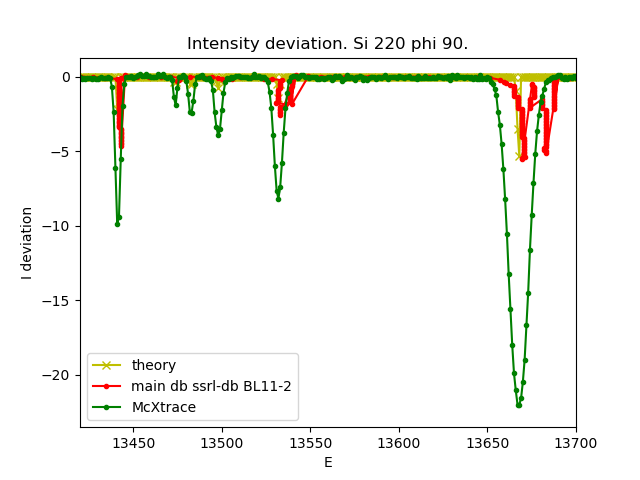

In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
########### Plot 

src_choice = int(input("Input (0) for mono source, (1) for white source:"))

if src_choice==0:
    data_mcxtrace_filename = "./running_mcxtrace/mcxtrace_bl_11_2_not_white_src/energy_scan/mccode_mcstasscript_not_white_src.dat"
else:
    data_mcxtrace_filename = "./running_mcxtrace/mcxtrace_bl_11_2_white_src/energy_scan/mccode_mcstasscript_white_src.dat"

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

########### Get data from digitalized_data.txt, the digitalized ssrl db data
data_ssrl = np.loadtxt("digitalized_data.txt", encoding='utf-8-sig',delimiter=";")
size_data_ssrl = len(data_ssrl)
X_ssrl = np.zeros(size_data_ssrl)
Y_ssrl = np.zeros(size_data_ssrl)

i=0
for elt in data_ssrl:    
    X_ssrl[i] = 1000.0*elt[0]
    Y_ssrl[i] = elt[1]
    i+=1

########### Get data from theory_itsty_firstxtal.dat, the theory glitches
data_theory_glitches = np.loadtxt("theory_itsty_firstxtal.dat")
size_data_theory_glitches = len(data_theory_glitches)
X_theory_glitches = np.zeros(size_data_theory_glitches)
Y_theory_glitches = np.zeros(size_data_theory_glitches)
i=0
for elt in data_theory_glitches:
    X_theory_glitches[i] = elt[0]
    #relative intensities are of interest.
    Y_theory_glitches[i] = -elt[1]*(30.69/71350.83)
    i+=1
           
########### Get data from McXtrace's mccode.dat
try:
    monitor_number = int(input("Input the number of the monitor to plot( monitor 1 by default):")) 
except ValueError:
    monitor_number = 1

data_mcxtrace = np.loadtxt(data_mcxtrace_filename)
size_data_mcxtrace = len(data_mcxtrace)
X_mcxtrace = np.zeros(size_data_mcxtrace)
Y_mcxtrace = np.zeros(size_data_mcxtrace)
Y_mcxtrace_nan = np.zeros(size_data_mcxtrace)
#what is above the threshold isn't a glitch
#what is under is
threshold = 0.999
not_in_glitch = 1
i=0
for elt in data_mcxtrace:    
    X_mcxtrace[i]=elt[0]
    Y_mcxtrace[i]=elt[monitor_number]
    Y_mcxtrace_nan[i]=elt[monitor_number]
    i+=1
      
max_Y_mcxtrace = max(Y_mcxtrace)    
 
#### Get rid of glitches, detect where they are and nan the portions, then replace the nans by interpolation       
i=0
for elt in data_mcxtrace:
    if i!=0 and i!=(size_data_mcxtrace-1):
      y_diff_sign = Y_mcxtrace[i]-Y_mcxtrace[i-1]
      if y_diff_sign<0:
        y_diff_sign = -1
        y_div = Y_mcxtrace[i]/Y_mcxtrace[i-1]
      else:
        y_diff_sign = 1
        y_div = Y_mcxtrace[i-1]/Y_mcxtrace[i]
        
      y_diff = np.abs(Y_mcxtrace[i]-Y_mcxtrace[i-1])
            
      if not_in_glitch==1:
        if y_div<threshold:
          not_in_glitch = 0          
      elif not_in_glitch==0: 
        if y_div>threshold:
          if(y_diff_sign>=1):
            if((Y_mcxtrace[i]/Y_mcxtrace[i+1])>threshold): #also the point after it
              not_in_glitch=1
          
      if not_in_glitch==0:
        Y_mcxtrace_nan[i] = np.nan
        
    i+=1    
    
not_nan = np.logical_not(np.isnan(Y_mcxtrace_nan))
indices = np.arange(len(Y_mcxtrace_nan))
without_glitches = np.interp(indices, indices[not_nan], Y_mcxtrace_nan[not_nan])
max_without_glitches = max(without_glitches)

for i,elt in enumerate(without_glitches):
    without_glitches[i]=(without_glitches[i]/max_without_glitches)*100

for i,elt in enumerate(Y_mcxtrace):
    Y_mcxtrace[i]=(Y_mcxtrace[i]/max_Y_mcxtrace)*100

#moving avg
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
#window length of the moving avg
#Ask the number of points to be taken to calculate the moving average
nn = int(input("Number of points of the moving average's window(this depends on the length of your scan, source's dE): "))
#nn=50 #500, compare
o = moving_average(without_glitches, nn)
y_padded = np.pad(o, (nn//2, nn-1-nn//2), mode='edge')

print("shape",y_padded.shape,without_glitches.shape)

#Uncomment to look at the normal plot and the plot without the glitches
#Check that it is correct before looking at the plot of Y_mcxtrace 
#plt.plot(X_mcxtrace, Y_mcxtrace, marker='x', color="r")
#plt.plot(X_mcxtrace, y_padded,marker='x', color="g")

#take off the moving avg without the glitches from the original plot with glitches
for i,elt in enumerate(Y_mcxtrace):
    Y_mcxtrace[i]=Y_mcxtrace[i]-y_padded[i]

#optional, you can try to bring a glitch to the same intensity as one of the ssrl glitches to see if the other glitches fit
for i,elt in enumerate(Y_mcxtrace):
    Y_mcxtrace[i]=Y_mcxtrace[i]*(30.69/95.69)

plt.title("Intensity deviation. Si 220 phi 90.")
plt.xlabel("E")
plt.ylabel("I deviation")

plt.plot(X_theory_glitches, Y_theory_glitches, marker='x', color="y", label='theory')
plt.plot(X_ssrl, Y_ssrl, marker='.', color="r", label='main db ssrl-db BL11-2')
plt.plot(X_mcxtrace, Y_mcxtrace, marker='.', color="g", label='McXtrace')

plt.legend(fontsize=10)
plt.xlim((X_mcxtrace[0],X_mcxtrace[-1]))
plt.show()

### Plots of entire range  <a name="plot_entire_range"></a> 

Here are plots that have been prearranged for both sources from 4.5 to 27 keV.  

The relative intensities are of interest. The intensities of the McXtrace and theory glitches found at the 6457 eV energy are made to be equal to an intensity deviation of 30.7 degrees which is the value of the ssrl database for that energy. In doing so, the relative intensities can be compared.  


#### White light (use of detuning for harmonic rejection)

<IPython.core.display.Javascript object>


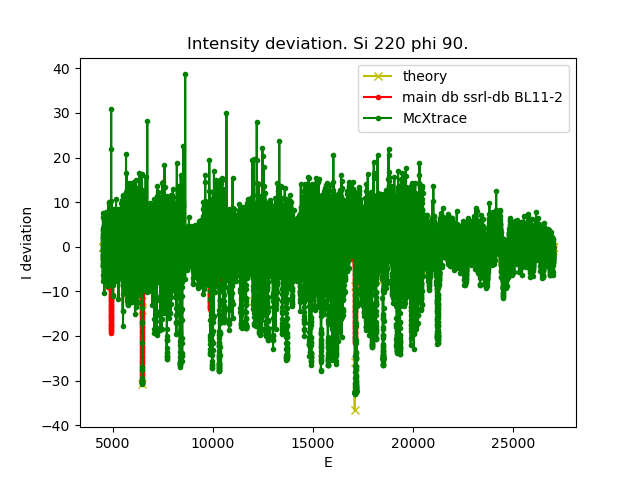

In [16]:
%matplotlib notebook
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
import remove_moving_avg_module

There is too much noise.

#### Nearly monochromatic light (dE=100eV)

<IPython.core.display.Javascript object>


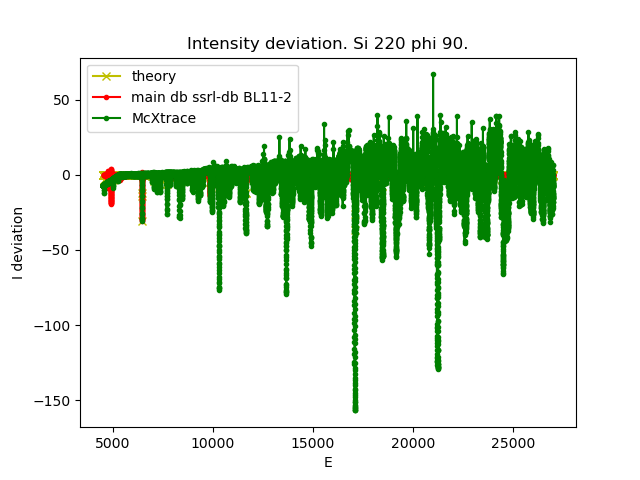

In [17]:
%matplotlib notebook
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
import remove_moving_avg_2_module

The noise is less of a problem here.  
The McXtrace data at the beginning isn't properly brought back to the baseline, this is due to the fact that the moving average can not be properly calculated near the extremities (because of the length of the moving average's window).  
For the McXtrace data, when zooming in on certain glitches(the one at 7196 eV for example), it is noticeable that they are formed by two distinguishable dips. This is not the case for the ssrl data. This problem has yet to be elucidated.  

#### Monochromatic light (dE=1eV)

In the following, the scan was done with a source of dE=1eV.

<IPython.core.display.Javascript object>


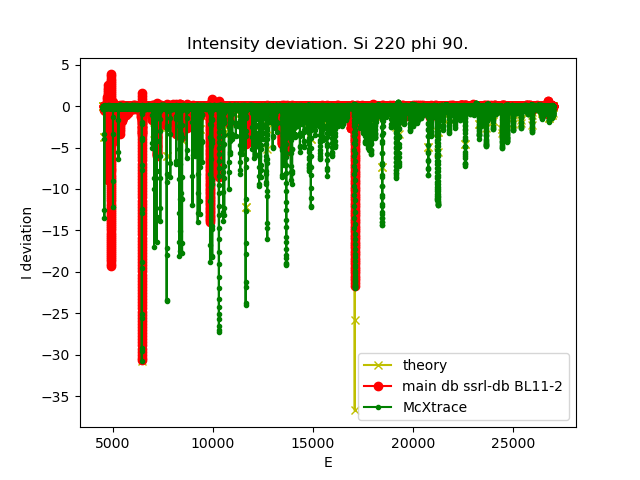

In [18]:
%matplotlib notebook
import sys
if './modules' not in sys.path:
    sys.path.append('./modules')
import remove_moving_avg_3_module


The noise has gone away. The double dip glitch problem described above also.  

# Interpretation <a name="interpretation"></a> 
[[back to toc]](#toc)

Looking at the McXtrace data, the positions of the dips are (mostly) correct. The deviations intensities aren't. 
Some procedures done above might differ from the ones ssrl-glitch db has done and therefore lead to the deviations intensities not matching.  
The relative intensities of the McXtrace and theory glitches correspond to each other (mostly).   
More glitches are found in the theory and McXtrace data compared to ssrl's data.  

A noticeable difference between the white source and the narrower sources is illustrated when zooming in on the 4500-5050 eV range.   
The two glitches at the energies 4589 and 5020 ev that are found in the theory glitches are also found with McXtrace. This is expected.  
But the interesting part is the intensity deviations at approximately 4755 and 4929 eV that are also found. And these are not found as theory glitches nor when the narrower sources are used. This is the interesting part where one does not expect any intensity dip, yet there are some found both in ssrl db and McXtrace.  

The white source and the de=100 eV source have some of their glitches formed by two dips. This is not the case for the de=1 eV source. The energy and angular divergence of the beam arriving on the crystals are at play in this problem but the exact cause of it is not understood.  

## Deviation intensity problem  <a name="deviation_intensity_problem"></a> 
[[back to toc]](#toc)

Using a large source leads to faulty intensity deviations because the statistics are not good enough. For instance, the number of rays hitting the principal plane of diffraction is too low.  
An interesting result is that the large source gives some intensity dips (also found on ssrl database) that are not seen when using a (nearly) monochromatic source. This can be seen when zooming in between 4500 and 5050 eV as described above.

When using a (nearly) monochromatic source, the statistics are high enough, the glitches follow mostly the intensity deviations of their respective `F^2` reflections found in the Si.lau file.  
The source having an energy and angular divergence contributes to the "filling up" of glitches.  

To know more about the above, check the gitlab documentation found [here](https://gitlab.synchrotron-soleil.fr/grades/beamlines/-/tree/main/glitches/deviation_intensity). Older documentation can also be found at the same place.

# Resources used <a name="resources_used"></a> 
[[back to toc]](#toc)

[hkl plane visualizer](http://ressources.univ-lemans.fr/AccesLibre/UM/Pedago/physique/02/cristallo/planreti.html)

[another hkl plane visualizer](http://lampx.tugraz.at/~hadley/ss1/crystalstructure/structures/diamond/diamond.php)

[Crystallography and reciprocal space video](https://www.youtube.com/watch?v=DFFU39A3fPY)  
 
[Diamond crystal structure](https://web.iitd.ac.in/~ajeetk/AML736/Assignment2_Prob3.pdf) 

"Some considerations on glitches and the design of a double crystal monochromator with bent crystals", P. van Zuylen, M.J. van der Hoek, 248 / SP /E Vol. 733 Soft X -Ray Optics and Technology (1986)

[Detuning (ssrl)](https://www-ssrl.slac.stanford.edu/mes/xafs/index.html#Detune)

[Beamline 11-2 (ssrl)](https://www-ssrl.slac.stanford.edu/mes/11-2/manual.php)

[4.5 to 27 keV energy scan with the Beamline 11-2 and the monochromator Si 220 PHI 90](https://www-ssrl.slac.stanford.edu/smbin/dataextractnew.pl?trace1=si22090112&trace2=None&trace3=None&trace4=None&lowrange=4.5&highrange=27&graph=1&kvalyes=0)

[Glitch_Curves (another dataset from ssrl)](https://www-ssrl.slac.stanford.edu/mes/Glitch_Curves/)

[Glitch/detuning procedure (ssrl)](https://www-ssrl.slac.stanford.edu/smbxas/beamlines/crystalsets.html)

[SPEAR III (ssrl)](https://accelconf.web.cern.ch/pac97/papers/pdf/6v049.pdf)

[Another SPEAR III document (ssrl)](http://cds.cern.ch/record/553174/files/tucl6.pdf)

[Beamline 11-2 update](https://www-ssrl.slac.stanford.edu/mes/BL_11_update.htm)

[SSRL XAS Beam Lines Soft X-ray](https://slideplayer.com/slide/8079219/)

[Introduction to EXAFS III: XANES, Distortions, Debye-Waller, Glitches](https://www.slideserve.com/earl/introduction-to-exafs-iii-xanes-distortions-debye-waller-glitches)

[Introduction to the Practical Aspects of XAS and EXAFS data Measurement. Part 1](https://www.youtube.com/watch?v=xpv5-DLzX1g)

[Introduction to the Practical Aspects of XAS and EXAFS data Measurement. Part 4](https://www.youtube.com/watch?v=ppsB4_pavbE)
 
[Sources and Optics for XAS](https://www-ssrl.slac.stanford.edu/conferences/workshops/srxas2008/talks/apurva_xas_summer_school08.pdf)

[Old code and documentation preceding this notebook](https://gitlab.synchrotron-soleil.fr/grades/beamlines/-/tree/main/glitches)